# Spectral Graph Theory Meets Coined Quantum Walks
## Notebook: Simulations for Dispersion, Revivals, and Search on Symmetric Graphs

This notebook reproduces the plots and metrics described in the report:

- **Cycles/Paths:** compare classical diffusion vs coined quantum ballistic spreading using **variance growth**.
- **Cycles:** compare **return probability** (revivals) for classical vs quantum.
- **Complete graphs:** compare **classical hitting-by-time** (per-step checking) vs **quantum end-only measurement** success (symmetry-reduced dynamics).

**Conventions (important):**
- Classical walk: iterate a **stochastic transition matrix** on a probability vector.
- Quantum walk on cycles/paths: discrete-time **coined quantum walk** with a 2D coin, using a **unitary** step `U = S (I ⊗ C)`.
- Measurement: for transport plots, we compute the position marginal `p_t(v)` at each time `t` (end-only; no intermediate measurements).
- Complete graph search: we implement the **symmetry-reduced** (2D) evolution equivalent to Grover-style rotation, and we plot `p_t(m)` under end-only measurement.

The code is written to make the classical and quantum pipelines comparable: same vertex indexing, same metrics, and explicit measurement protocol choices.


## Environment / Dependencies

This notebook was run with:

- **Python**: 3.10+ (works with 3.9+ as well)

### Required packages
- `numpy`
- `scipy`
- `matplotlib`
- `networkx`
- `pandas` *(optional; only if you use DataFrames for tables/logging)*
- `tqdm` *(optional; only if you show progress bars)*

### Reproducibility notes
- If any randomized experiments are run, results can be reproduced by setting a fixed seed (e.g., `np.random.seed(0)`).
- All plots and reported metrics in the report are generated from this notebook.

### Quick install (pip)
If you want to recreate the environment locally:

```bash
python -m venv .venv
source .venv/bin/activate   # (Windows: .venv\Scripts\activate)
pip install numpy scipy matplotlib networkx pandas tqdm


## 0. Reproducibility and conventions


We fix graph labeling, what counts as one step, and measurement timing so every plot is comparable.


In [23]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)

# Part A — Classical graphs and transition matrices

We build **row-stochastic** transition matrices `P` for each graph family so that classical evolution is

\[
p_{t+1} = p_t P,
\]

where `p_t` is a probability **row** vector over vertices.

Graph families covered here:
- Cycle `C_n`
- Path `P_n`
- Complete graph `K_n`

(We keep vertex labels `0,1,...,n-1` and use the same labeling later for quantum plots.)


## A.1 Transition-matrix constructors

Below are explicit constructors for:
- `P_cycle(n)` for the simple random walk on `C_n`
- `P_path(n)` for the simple random walk on `P_n` (endpoints have degree 1)
- `P_complete(n)` for the simple random walk on `K_n` (no self-loops)


In [24]:
def P_cycle(n: int) -> np.ndarray:
    """
    Simple random walk on the cycle C_n (degree 2 everywhere).
    From i -> i-1 mod n and i+1 mod n with probability 1/2 each.
    Returns an (n x n) row-stochastic matrix P with p_{t+1} = p_t P.
    """
    if n < 3:
        raise ValueError("Cycle C_n is usually defined for n >= 3.")
    P = np.zeros((n, n), dtype=float)
    for i in range(n):
        P[i, (i - 1) % n] = 0.5
        P[i, (i + 1) % n] = 0.5
    return P


def P_path(n: int) -> np.ndarray:
    """
    Simple random walk on the path P_n on vertices 0..n-1.
    Endpoints have one neighbor; internal vertices have two.
    Returns an (n x n) row-stochastic matrix.
    """
    if n < 2:
        raise ValueError("Path P_n requires n >= 2.")
    P = np.zeros((n, n), dtype=float)
    for i in range(n):
        nbrs = []
        if i - 1 >= 0:
            nbrs.append(i - 1)
        if i + 1 < n:
            nbrs.append(i + 1)
        deg = len(nbrs)
        for j in nbrs:
            P[i, j] = 1.0 / deg
    return P


def P_complete(n: int) -> np.ndarray:
    """
    Simple random walk on the complete graph K_n (degree n-1 everywhere).
    From i -> j (j != i) with probability 1/(n-1); no self-loop.
    Returns an (n x n) row-stochastic matrix.
    """
    if n < 2:
        raise ValueError("Complete graph K_n requires n >= 2.")
    P = (np.ones((n, n), dtype=float) - np.eye(n, dtype=float)) / (n - 1)
    return P


## A.2 Sanity checks for stochastic matrices

For each transition matrix `P`, we verify the two defining properties of a row-stochastic matrix:

1. **Nonnegativity:** all entries are ≥ 0 (up to tiny numerical tolerance).
2. **Row sums:** each row sums to 1 (so probability mass is preserved under `p_{t+1} = p_t P`).

We also print a small diagnostic: the minimum entry and the maximum row-sum deviation from 1.


In [25]:
def check_row_stochastic(P: np.ndarray, name: str = "P", tol: float = 1e-12) -> None:
    """
    Sanity-check that P is row-stochastic: entries >= 0 and each row sums to 1.
    Prints diagnostics and raises AssertionError if checks fail.
    """
    if P.ndim != 2 or P.shape[0] != P.shape[1]:
        raise ValueError(f"{name}: expected a square matrix, got shape {P.shape}.")

    min_entry = P.min()
    row_sums = P.sum(axis=1)
    max_row_sum_dev = np.max(np.abs(row_sums - 1.0))

    print(f"[{name}] shape={P.shape}  min_entry={min_entry:.3e}  max|row_sum-1|={max_row_sum_dev:.3e}")

    assert min_entry >= -tol, f"{name}: has negative entries below -tol (min={min_entry})."
    assert np.allclose(row_sums, 1.0, atol=tol), f"{name}: rows do not sum to 1 within tol={tol}."


# tests on a few sizes
for n in [5, 10]:
    check_row_stochastic(P_cycle(n), name=f"P_cycle({n})")

for n in [2, 5, 10]:
    check_row_stochastic(P_path(n), name=f"P_path({n})")

for n in [2, 5, 10]:
    check_row_stochastic(P_complete(n), name=f"P_complete({n})")


[P_cycle(5)] shape=(5, 5)  min_entry=0.000e+00  max|row_sum-1|=0.000e+00
[P_cycle(10)] shape=(10, 10)  min_entry=0.000e+00  max|row_sum-1|=0.000e+00
[P_path(2)] shape=(2, 2)  min_entry=0.000e+00  max|row_sum-1|=0.000e+00
[P_path(5)] shape=(5, 5)  min_entry=0.000e+00  max|row_sum-1|=0.000e+00
[P_path(10)] shape=(10, 10)  min_entry=0.000e+00  max|row_sum-1|=0.000e+00
[P_complete(2)] shape=(2, 2)  min_entry=0.000e+00  max|row_sum-1|=0.000e+00
[P_complete(5)] shape=(5, 5)  min_entry=0.000e+00  max|row_sum-1|=0.000e+00
[P_complete(10)] shape=(10, 10)  min_entry=0.000e+00  max|row_sum-1|=0.000e+00


In [26]:
def check_stochastic(P: np.ndarray, name: str = "P", atol: float = 1e-12) -> None:
    """
    Backwards-compatible name used elsewhere in the notebook.
    Equivalent to check_row_stochastic (row-stochastic transition matrix check).
    """
    return check_row_stochastic(P, name=name, tol=atol)


# Part B — Classical random walk simulator

We propagate an *exact* probability distribution forward in time (no sampling).  
Given a row-stochastic transition matrix `P`, we compute `p_{t+1} = p_t @ P` and store the full time series.


## B.1 Classical evolution routine


Implement probs[t,v] for t=0..T starting from a delta distribution at vertex s.


In [27]:
def classical_walk(P: np.ndarray, s: int, T: int, p0: np.ndarray | None = None) -> np.ndarray:
    """
    Return probs[t, v] for t=0..T for a classical random walk with transition matrix P.
    Convention: p_{t+1} = p_t @ P (row vector evolution).

    If p0 is None, initialize at the delta distribution at vertex s.
    Output shape: (T+1, n)
    """
    P = np.asarray(P, dtype=float)
    if P.ndim != 2 or P.shape[0] != P.shape[1]:
        raise ValueError(f"P must be square, got shape {P.shape}.")
    n = P.shape[0]
    if not (0 <= s < n):
        raise ValueError(f"s must be in [0, {n-1}], got {s}.")
    if T < 0:
        raise ValueError("T must be nonnegative.")

    # Optional safety check (comment out if you want speed)
    check_stochastic(P, name="P")

    if p0 is None:
        p = np.zeros(n, dtype=float)
        p[s] = 1.0
    else:
        p = np.asarray(p0, dtype=float).copy()
        if p.shape != (n,):
            raise ValueError(f"p0 must have shape ({n},), got {p.shape}.")
        total = p.sum()
        if total <= 0:
            raise ValueError("p0 must sum to a positive value.")
        p /= total  # normalize defensively

    probs = np.zeros((T + 1, n), dtype=float)
    probs[0] = p
    for t in range(T):
        probs[t + 1] = probs[t] @ P
    return probs

# Part C — Coined quantum walk on cycles and paths

We implement a **discrete-time coined quantum walk** on degree-2 graphs (cycles and paths). The walker’s state lives in a tensor-product space:

- **Position register**: vertices `v = 0,1,...,n-1`
- **Coin register**: two directions, which we index as:
  - `c = 0` = “left”
  - `c = 1` = “right”

We store the quantum state as a complex array `psi` of shape `(n, 2)` where `psi[v, c]` is the amplitude of being at vertex `v` with coin state `c`.

A single coined-walk **step** is:
1. Apply a fixed `2×2` unitary coin `C` to the coin register *at every vertex*.
2. Apply a **shift** that moves the `left` amplitude one vertex left and the `right` amplitude one vertex right.

For paths, we use a **reversible “bounce” boundary rule** at the endpoints so that the shift remains a permutation of basis states (hence unitary).


## C.1 State layout and probability extraction

To compare against classical walks, we measure only the **position** register.

Given `psi[v,c]`, the induced **vertex probability distribution** is the position marginal
\[
p(v) = \sum_{c\in\{0,1\}} |\psi[v,c]|^2.
\]

This is what we plot for transport experiments (cycles/paths), and it is what we use to compute metrics like variance and return probability. A basic sanity check is that `p(v)` is nonnegative and sums to `1` (up to numerical tolerance) when `psi` is normalized.


In [28]:
def position_marginal(psi: np.ndarray) -> np.ndarray:
    """
    Given psi of shape (n,2) with complex amplitudes, return vertex probabilities p of shape (n,).
    p[v] = |psi[v,0]|^2 + |psi[v,1]|^2
    """
    psi = np.asarray(psi)
    if psi.ndim != 2 or psi.shape[1] != 2:
        raise ValueError(f"psi must have shape (n,2); got {psi.shape}")
    p = np.sum(np.abs(psi)**2, axis=1)
    # numerical cleanup
    p = np.real_if_close(p, tol=1e8)
    return p


## C.2 Coin operators

The coin operator is a fixed `2×2` **unitary** that mixes the left/right amplitudes at each vertex before shifting.

We provide:
- **Hadamard coin** (balanced mixing), commonly used for degree-2 walks:
  \[
  H = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}.
  \]
- (Optional) **Grover coin for d=2**, which is the reflection about the uniform coin state. For `d=2` this simplifies to the swap matrix:
  \[
  G_2 = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}.
  \]

In the experiments, using a fixed symmetric coin ensures the observed differences come from the walk dynamics and the graph structure rather than from an asymmetric direction bias.


In [29]:
def coin_hadamard() -> np.ndarray:
    """
    Standard 2D Hadamard coin (unitary).
    """
    return (1/np.sqrt(2)) * np.array([[1,  1],
                                     [1, -1]], dtype=complex)

def coin_grover_d2() -> np.ndarray:
    """
    Grover coin for d=2: 2|s><s| - I with |s> = (1,1)/sqrt(2).
    For d=2 this simplifies to the swap matrix.
    """
    return np.array([[0, 1],
                     [1, 0]], dtype=complex)


## C.3 Shift rules and boundary handling

The shift moves amplitudes along edges according to the coin label:

- On a **cycle** `C_n`, indices wrap modulo `n`:
  - left amplitude at `v` moves to `v-1 (mod n)`
  - right amplitude at `v` moves to `v+1 (mod n)`

- On a **path** `P_n`, we must handle endpoints without breaking unitarity.
  We use a **bounce rule**:
  - At the left endpoint `v=0`, “left” would step out of bounds, so it reflects into “right” at the same vertex.
  - At the right endpoint `v=n-1`, “right” reflects into “left” at the same vertex.
  - All other amplitudes shift normally inward.

This bounce shift is a bijection on the computational basis states, so it is a valid unitary shift operator.


In [30]:
def shift_cycle(psi: np.ndarray) -> np.ndarray:
    """
    Shift on C_n with coin labels:
      c=0 (left): v -> v-1 mod n
      c=1 (right): v -> v+1 mod n
    This is a permutation of basis states, hence unitary.
    """
    psi = np.asarray(psi)
    if psi.ndim != 2 or psi.shape[1] != 2:
        raise ValueError(f"psi must have shape (n,2); got {psi.shape}")
    n = psi.shape[0]
    out = np.zeros_like(psi, dtype=complex)

    # left coin: new[v] gets old[v+1]
    out[:, 0] = np.roll(psi[:, 0], shift=-1)
    # right coin: new[v] gets old[v-1]
    out[:, 1] = np.roll(psi[:, 1], shift=+1)
    return out

def shift_path_bounce(psi: np.ndarray) -> np.ndarray:
    """
    Shift on P_n with a reversible bounce at endpoints.

    Conventions:
      c=0 (left), c=1 (right)

    Interior moves:
      left:  v -> v-1
      right: v -> v+1

    Bounce:
      (0,left)    -> (0,right)
      (n-1,right) -> (n-1,left)

    This mapping is bijective on basis states, hence unitary.
    """
    psi = np.asarray(psi)
    if psi.ndim != 2 or psi.shape[1] != 2:
        raise ValueError(f"psi must have shape (n,2); got {psi.shape}")
    n = psi.shape[0]
    if n < 2:
        raise ValueError("Path length n must be at least 2 for a nontrivial walk.")

    out = np.zeros_like(psi, dtype=complex)

    # Left-moving amplitudes shift inward (v -> v-1) for v=1..n-1
    out[:-1, 0] = psi[1:, 0]
    # Right endpoint bounce: (n-1,right) -> (n-1,left)
    out[n-1, 0] = psi[n-1, 1]

    # Right-moving amplitudes shift inward (v -> v+1) for v=0..n-2
    out[1:, 1] = psi[:-1, 1]
    # Left endpoint bounce: (0,left) -> (0,right)
    out[0, 1] = psi[0, 0]

    return out


### C.4 One-step update and time evolution

One step is:
1. Apply coin \(C\) at each vertex (mix coin amplitudes locally).
2. Apply shift \(S\) once (move amplitudes along edges in a reversible way).

We implement:
- `quantum_step_degree2(psi, C, shift_fn)`
- `quantum_walk_degree2(n, s, T, C, shift_fn)` returning `probs[t, v]`.


In [31]:
def quantum_step_degree2(psi: np.ndarray, C: np.ndarray, shift_fn) -> np.ndarray:
    """
    One coined-walk step on a degree-2 graph:
      1) coin: apply C to coin register at each vertex
      2) shift: apply a reversible shift permutation
    """
    psi = np.asarray(psi, dtype=complex)
    C = np.asarray(C, dtype=complex)

    # coin acts on the last axis; with psi[v,:] as a row vector, use C^T
    psi_coin = psi @ C.T
    psi_next = shift_fn(psi_coin)
    return psi_next

def quantum_walk_degree2(n: int, s: int, T: int, C: np.ndarray, shift_fn) -> np.ndarray:
    """
    Run a coined quantum walk for T steps on n vertices starting at vertex s.
    We initialize with a symmetric coin state to avoid bias:
        psi[s,:] = (1/sqrt(2)) * (|L> + |R>)
    Returns probs[t, v] of shape (T+1, n).
    """
    psi = np.zeros((n, 2), dtype=complex)
    psi[s, :] = 1 / np.sqrt(2)

    probs = np.zeros((T + 1, n), dtype=float)
    probs[0] = position_marginal(psi)

    for t in range(1, T + 1):
        psi = quantum_step_degree2(psi, C, shift_fn)
        probs[t] = position_marginal(psi)

    return probs


### C.5 Quantum sanity checks

We confirm the induced vertex probabilities sum to 1 at every time step (within tolerance). This is a practical check that our step operator is behaving unitarily and that probability extraction is correct.


In [32]:
def check_probs(probs: np.ndarray, tol: float = 1e-10, verbose: bool = True) -> bool:
    """
    Check that each time-slice distribution sums to 1 (within tol) and is nonnegative (within tol).
    probs can be shape (T+1, n).
    """
    probs = np.asarray(probs, dtype=float)
    sums = probs.sum(axis=1)
    minp = probs.min() if probs.size else 0.0

    ok_sum = np.all(np.abs(sums - 1.0) <= tol)
    ok_nonneg = (minp >= -tol)

    if verbose:
        print("min prob:", minp)
        print("sum range:", sums.min(), sums.max())
        print("ok sums:", ok_sum, " | ok nonneg:", ok_nonneg)

    return bool(ok_sum and ok_nonneg)

# smoke test: cycle quantum walk probability normalization
n, s, T = 25, 12, 30
q_probs = quantum_walk_degree2(n, s, T, coin_hadamard(), shift_cycle)
print("quantum cycle ok:", check_probs(q_probs, verbose=False))

# smoke test: path quantum walk probability normalization
q_probs_path = quantum_walk_degree2(n, s, T, coin_hadamard(), shift_path_bounce)
print("quantum path ok:", check_probs(q_probs_path, verbose=False))


quantum cycle ok: True
quantum path ok: True


# Part D — Metrics and summary statistics

All plots in later parts are derived from the same small set of metrics computed from a time series of vertex distributions `probs[t, v]`:

- **Return probability**: probability of being at the start vertex at time `t`.
- **Variance (spread)**: variance of the position distribution (relative to the start).
- **Time-to-threshold**: first time `t` that a success curve exceeds a chosen probability threshold.

We keep these as separate helper functions so the classical and quantum pipelines can share the exact same metric code.


From vertex distributions we compute spread (variance), recurrence (return probability), and search success curves.


## D.1 Return probability

Given `probs[t, v]`, the return probability to a start vertex `s` is simply `probs[t, s]` for each time `t`.


In [33]:
def return_prob(probs: np.ndarray, s: int) -> np.ndarray:
    """
    Return probability curve r[t] = probs[t, s].

    probs: array of shape (T+1, n)
    s: start vertex index
    """
    probs = np.asarray(probs)
    if probs.ndim != 2:
        raise ValueError(f"probs must be 2D (T+1, n), got shape {probs.shape}")
    T1, n = probs.shape
    if not (0 <= s < n):
        raise ValueError(f"s must be in [0, {n-1}], got {s}")
    return probs[:, s].copy()


## D.2 Variance / spread on paths and cycles

For a **path**, we treat vertices as lying on a line and measure positions relative to the start `s` using `x(v) = v - s`.

For a **cycle**, vertex labels wrap around, so a naïve linear coordinate can create artificial jumps. We instead convert each vertex `v` to its **signed shortest displacement** from `s` around the cycle (an integer in a symmetric range around 0). This gives a stable “prewrap-style” variance that behaves well even as the walk spreads.


In [34]:
def variance_path(probs: np.ndarray, s: int) -> np.ndarray:
    """
    Variance curve on a path using linear coordinates x(v) = v - s.

    probs: array of shape (T+1, n)
    s: start vertex
    returns: var[t] for t=0..T
    """
    probs = np.asarray(probs)
    if probs.ndim != 2:
        raise ValueError(f"probs must be 2D (T+1, n), got shape {probs.shape}")
    T1, n = probs.shape
    if not (0 <= s < n):
        raise ValueError(f"s must be in [0, {n-1}], got {s}")

    x = (np.arange(n) - s).astype(float)  # positions relative to s
    mean = probs @ x
    mean2 = probs @ (x**2)
    var = mean2 - mean**2
    return var


def variance_cycle_prewrap(probs: np.ndarray, s: int) -> np.ndarray:
    """
    "Prewrap-style" variance on a cycle using signed shortest displacement from s.

    We map each vertex v to an integer displacement d(v) in a symmetric range around 0:
        d(v) = signed_shortest(v - s mod n)

    This avoids artificial jumps due to wrap-around in vertex labels.

    probs: array of shape (T+1, n)
    s: start vertex
    returns: var[t] for t=0..T
    """
    probs = np.asarray(probs)
    if probs.ndim != 2:
        raise ValueError(f"probs must be 2D (T+1, n), got shape {probs.shape}")
    T1, n = probs.shape
    if not (0 <= s < n):
        raise ValueError(f"s must be in [0, {n-1}], got {s}")

    # displacement i - s wrapped to [0, n-1]
    delta = (np.arange(n) - s) % n

    # convert to signed shortest displacement:
    # for odd n: range is [-(n//2), ..., (n//2)]
    # for even n: range is [-(n//2), ..., (n//2 - 1)]
    half = n // 2
    d = delta.astype(int)
    d = np.where(d > half, d - n, d)          # push large positives negative
    if n % 2 == 0:
        # tie case when delta == n/2: choose negative direction for consistency
        d = np.where(d == half, d - n, d)

    x = d.astype(float)
    mean = probs @ x
    mean2 = probs @ (x**2)
    var = mean2 - mean**2
    return var


## D.3 Time-to-threshold

Given a success curve `S_t` (e.g., marked-vertex probability under end-only measurement, or hit-by-time under per-step checking), `T_p` is the smallest `t` such that `S_t >= p`.

If the threshold is never reached, we return `None`.


In [35]:
from typing import Optional

def time_to_threshold(series: np.ndarray, p: float = 0.5) -> Optional[int]:
    """
    Return the smallest t such that series[t] >= p.
    If never reached, return None.

    series: array-like of shape (T+1,)
    p: threshold in [0,1]
    """
    s = np.asarray(series, dtype=float)
    if s.ndim != 1:
        raise ValueError(f"series must be 1D, got shape {s.shape}")
    if not (0.0 <= p <= 1.0):
        raise ValueError(f"p must be in [0,1], got {p}")

    idx = np.where(s >= p)[0]
    return int(idx[0]) if idx.size > 0 else None


# Part E — Experiments on cycles and paths

We now use the simulators from Parts B/C and the shared metrics from Part D to reproduce the qualitative behaviors discussed in the report:

- **Dispersion (cycles):** classical diffusion vs coined quantum “ballistic” spreading, using variance growth.
- **Distribution snapshots (cycles):** see how the full vertex distribution evolves over time.
- **Revivals (cycles):** compare **return probability** to the start vertex.
- **Boundary effects (paths):** show reflections under the reversible endpoint (“bounce”) shift rule.

Conventions:
- Classical evolution: `probs[t+1] = probs[t] @ P`.
- Quantum evolution: end-only measurement; after each unitary step we extract the position marginal `p_t(v)` by summing squared magnitudes over coin states.


We reproduce diffusion vs ballistic spreading and compare return probabilities over time.


## E.1 Dispersion: variance growth on \(C_n\)

We compare variance growth on a cycle starting from a single vertex. For a cycle we use the **prewrap variance** metric from Part D (signed shortest displacement from the start) so wrap-around does not create artificial jumps in the coordinate.


[P] shape=(101, 101)  min_entry=0.000e+00  max|row_sum-1|=0.000e+00
min prob: 0.0
sum range: 0.9999999999999999 1.0000000000000002
ok sums: True  | ok nonneg: True
min prob: 0.0
sum range: 0.9999999999999857 0.9999999999999998
ok sums: True  | ok nonneg: True


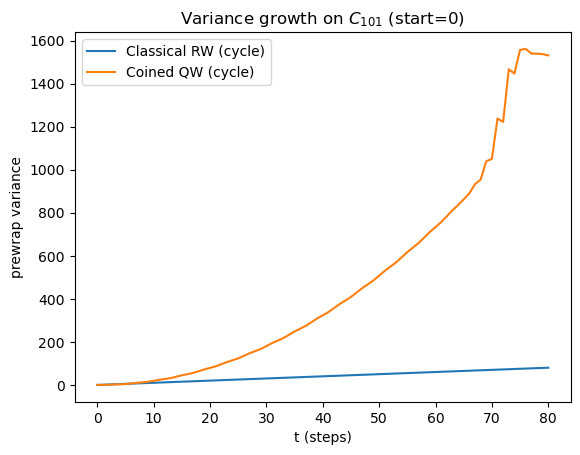

In [36]:
# --- parameters ---
n_cycle = 101          # choose odd to avoid some parity artifacts in classical oscillations
s_cycle = 0
T_cycle = 80

# --- classical walk ---
Pcyc = P_cycle(n_cycle)
probs_c_cycle = classical_walk(Pcyc, s_cycle, T_cycle)

# --- quantum walk (2D coin) ---
C2 = coin_hadamard()
probs_q_cycle = quantum_walk_degree2(n_cycle, s_cycle, T_cycle, C2, shift_cycle)

# --- sanity checks (if you implemented these helpers) ---
try:
    check_probs(probs_c_cycle)
    check_probs(probs_q_cycle)
except NameError:
    pass

# --- metrics ---
var_c_cycle = variance_cycle_prewrap(probs_c_cycle, s_cycle)
var_q_cycle = variance_cycle_prewrap(probs_q_cycle, s_cycle)

# --- plot ---
t = np.arange(T_cycle + 1)
plt.figure()
plt.plot(t, var_c_cycle, label="Classical RW (cycle)")
plt.plot(t, var_q_cycle, label="Coined QW (cycle)")
plt.title(f"Variance growth on $C_{{{n_cycle}}}$ (start={s_cycle})")
plt.xlabel("t (steps)")
plt.ylabel("prewrap variance")
plt.legend()
plt.show()


## E.2 Cycle distribution snapshots

To visualize *diffusion vs interference*, we plot the full vertex distribution at selected times.

- Classical RW: distribution smooths and flattens over time.
- Coined QW: distribution develops outward-moving peaks and oscillatory ripples due to interference.

We reuse the `probs_c_cycle` and `probs_q_cycle` arrays from **E.1**.


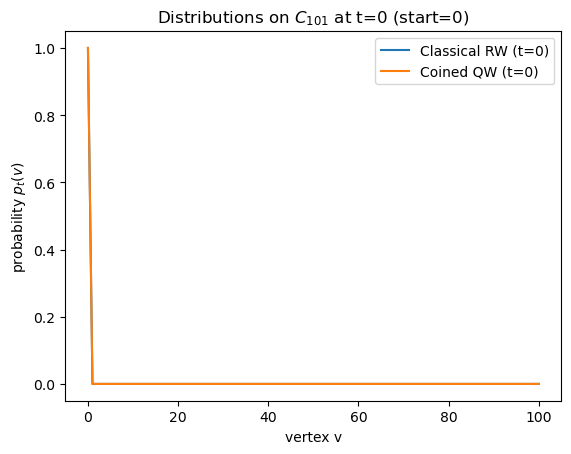

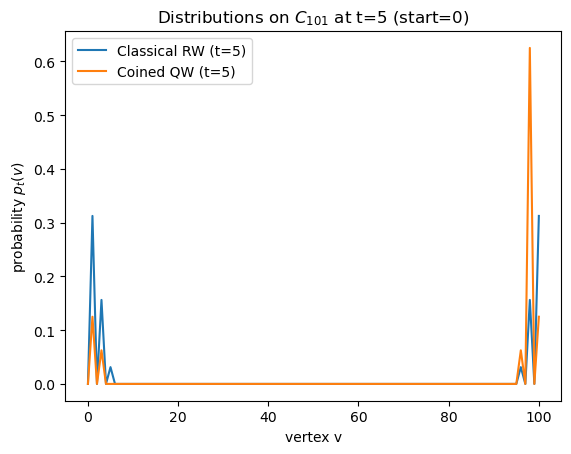

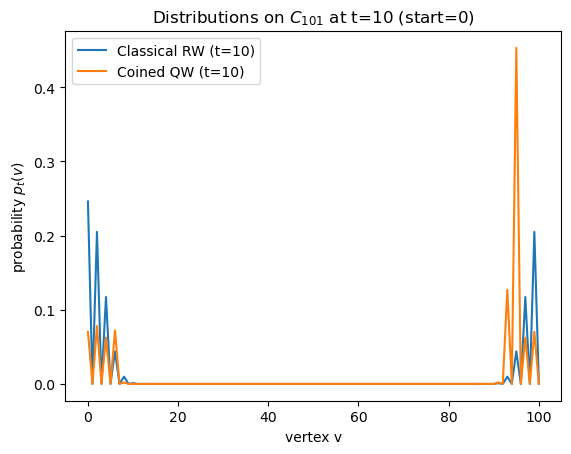

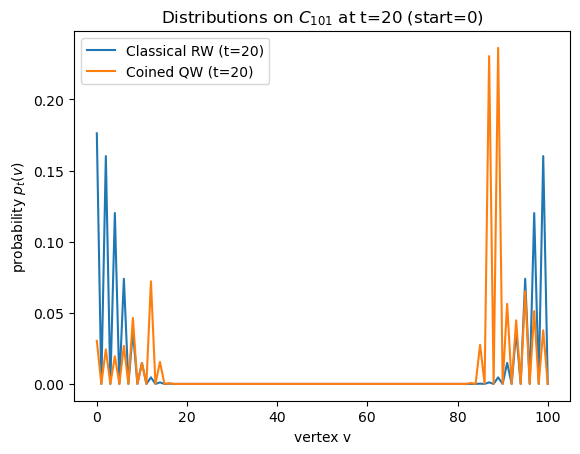

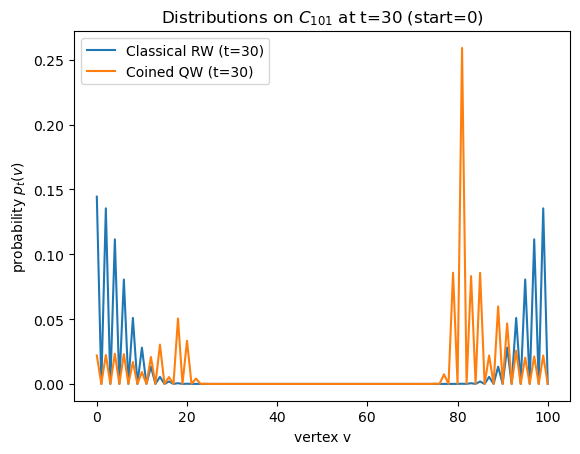

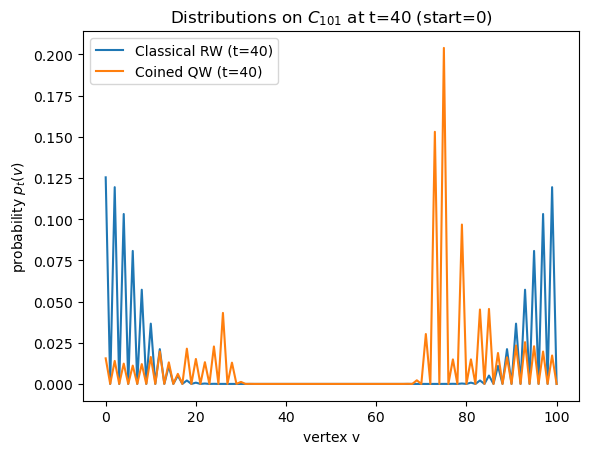

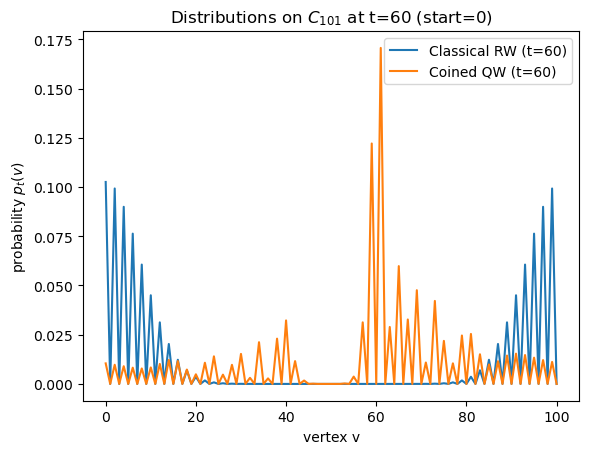

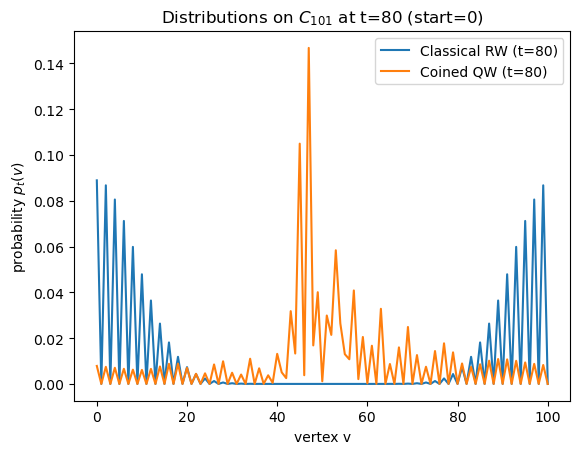

In [37]:
snapshot_ts = [0, 5, 10, 20, 30, 40, 60, 80]
snapshot_ts = [t for t in snapshot_ts if 0 <= t <= T_cycle]

v = np.arange(n_cycle)

for t_snap in snapshot_ts:
    plt.figure()
    plt.plot(v, probs_c_cycle[t_snap], label=f"Classical RW (t={t_snap})")
    plt.plot(v, probs_q_cycle[t_snap], label=f"Coined QW (t={t_snap})")
    plt.title(f"Distributions on $C_{{{n_cycle}}}$ at t={t_snap} (start={s_cycle})")
    plt.xlabel("vertex v")
    plt.ylabel(r"probability $p_t(v)$")
    plt.legend()
    plt.show()


## E.3 Cycle return probability

We compare the **return probability** to the start vertex `s`:
- Classical RW: tends to decay toward a spread-out baseline (may show mild parity effects).
- Coined QW: exhibits oscillations and revival-like peaks due to phase interference.

Return probability is `p_t(s) = probs[t, s]`, computed via the shared helper `return_prob`.


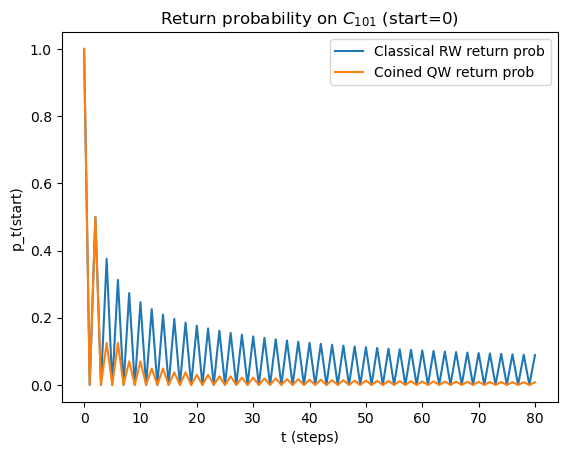

In [38]:
rp_c_cycle = return_prob(probs_c_cycle, s_cycle)
rp_q_cycle = return_prob(probs_q_cycle, s_cycle)

t = np.arange(T_cycle + 1)

plt.figure()
plt.plot(t, rp_c_cycle, label="Classical RW return prob")
plt.plot(t, rp_q_cycle, label="Coined QW return prob")
plt.title(f"Return probability on $C_{{{n_cycle}}}$ (start={s_cycle})")
plt.xlabel("t (steps)")
plt.ylabel("p_t(start)")
plt.legend()
plt.show()


## E.4 Path experiment

We repeat the same metrics on a path `P_n` to illustrate **boundary effects**.

- Classical RW on a path: diffusion with reflection at endpoints.
- Coined QW with the reversible **bounce** endpoint rule: coherent spreading plus visible reflections/interference from boundaries.

We measure:
1) variance on the path using linear coordinates `x(v) = v - s` (helper: `variance_path`)
2) return probability to the start (helper: `return_prob`)


[P] shape=(101, 101)  min_entry=0.000e+00  max|row_sum-1|=0.000e+00
min prob: 0.0
sum range: 0.9999999999999999 1.0000000000000002
ok sums: True  | ok nonneg: True
min prob: 0.0
sum range: 0.9999999999999784 0.9999999999999998
ok sums: True  | ok nonneg: True


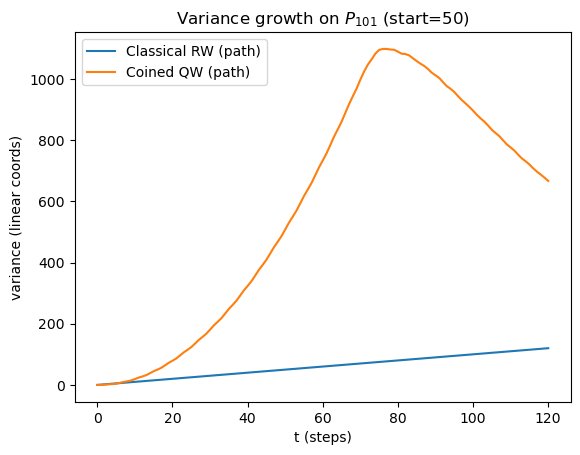

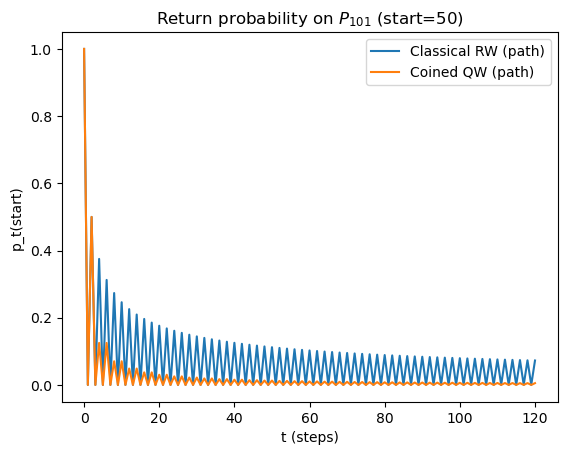

In [39]:
# --- parameters ---
n_path = 101
s_path = n_path // 2   # start in the middle
T_path = 120

# --- classical walk ---
Ppath = P_path(n_path)
probs_c_path = classical_walk(Ppath, s_path, T_path)

# --- quantum walk (2D coin + bounce shift) ---
C2 = coin_hadamard()
probs_q_path = quantum_walk_degree2(n_path, s_path, T_path, C2, shift_path_bounce)

# --- optional sanity checks ---
try:
    check_probs(probs_c_path)
    check_probs(probs_q_path)
except NameError:
    pass

# --- metrics ---
var_c_path = variance_path(probs_c_path, s_path)
var_q_path = variance_path(probs_q_path, s_path)

rp_c_path = return_prob(probs_c_path, s_path)
rp_q_path = return_prob(probs_q_path, s_path)

t = np.arange(T_path + 1)

# --- plot: variance ---
plt.figure()
plt.plot(t, var_c_path, label="Classical RW (path)")
plt.plot(t, var_q_path, label="Coined QW (path)")
plt.title(f"Variance growth on $P_{{{n_path}}}$ (start={s_path})")
plt.xlabel("t (steps)")
plt.ylabel("variance (linear coords)")
plt.legend()
plt.show()

# --- plot: return probability ---
plt.figure()
plt.plot(t, rp_c_path, label="Classical RW (path)")
plt.plot(t, rp_q_path, label="Coined QW (path)")
plt.title(f"Return probability on $P_{{{n_path}}}$ (start={s_path})")
plt.xlabel("t (steps)")
plt.ylabel("p_t(start)")
plt.legend()
plt.show()


# Part F — Marked-vertex search on complete graphs

We compare a **classical baseline** on \(K_n\) (hit-by-time under per-step checking) to a **symmetry-reduced quantum search** curve (end-only measurement) that peaks around \(O(\sqrt{n})\).

Conventions:

- Classical baseline: from an unmarked vertex on \(K_n\), the probability to move to the marked vertex in one step is \(p = 1/(n-1)\).  
  Hence the hit-by-time curve is \(S_t = 1 - (1-p)^t\).
- Quantum model: we use a 2D “Grover rotation” approximation where the success probability evolves as  
  \(p_t(m) = \sin^2((2t+1)\theta)\) with \(\theta = \arcsin(1/\sqrt{n})\).

We then (i) plot a single success curve for fixed \(n\), and (ii) sweep \(n\) to compare the empirical time-to-0.5 scaling.


# F.1: classical baseline on K_n 

We compute a classical target-finding baseline using the one-step hit probability and its implied time scale.


In [40]:
from typing import Tuple

def classical_hit_baseline_complete(n: int, T: int) -> Tuple[np.ndarray, float, np.ndarray]:
    """
    Classical hit-by-time baseline on K_n with one marked vertex.

    From any unmarked vertex, P(hit marked next step) = 1/(n-1).
    Under per-step checking, the probability of having hit by time t is:
        S[t] = 1 - (1 - p_step)^t

    Returns:
      S : array of shape (T+1,)  success-by-time curve
      p_step : one-step hit probability (float)
      expected_hit_scale : geometric mean steps = 1/p_step = n-1 (returned as float)
    """
    if n < 2:
        raise ValueError("n must be >= 2 for K_n.")
    if T < 0:
        raise ValueError("T must be nonnegative.")

    p_step = 1.0 / (n - 1)
    t = np.arange(T + 1, dtype=float)
    S = 1.0 - (1.0 - p_step) ** t
    expected_hit_scale = 1.0 / p_step  # = n-1
    return S, p_step, expected_hit_scale


## F.2 Low-dimensional quantum search model


Using symmetry, we model the evolution using only “marked” versus “uniform unmarked” components and iterate a 2D update.


In [41]:
def quantum_search_2d_success_curve(n: int, T: int) -> np.ndarray:
    """
    Symmetry-reduced 2D Grover-style success curve for 1 marked item among n.

    Model:
      theta = arcsin(1/sqrt(n))
      p_t = sin^2((2t+1)*theta)

    Returns:
      p : array of shape (T+1,) with p[t] = success probability at time t (end-only measurement).
    """
    if n < 2:
        raise ValueError("n must be >= 2.")
    if T < 0:
        raise ValueError("T must be nonnegative.")

    theta = np.arcsin(1.0 / np.sqrt(n))
    t = np.arange(T + 1, dtype=float)
    p = np.sin((2.0 * t + 1.0) * theta) ** 2
    return p


## F.3 Plot: success probability vs time for fixed n

We plot the symmetry-reduced quantum success probability \(p_t(m)\) over time (end-only measurement), and overlay the classical hit-by-time baseline \(S_t = 1-(1-1/(n-1))^t\).


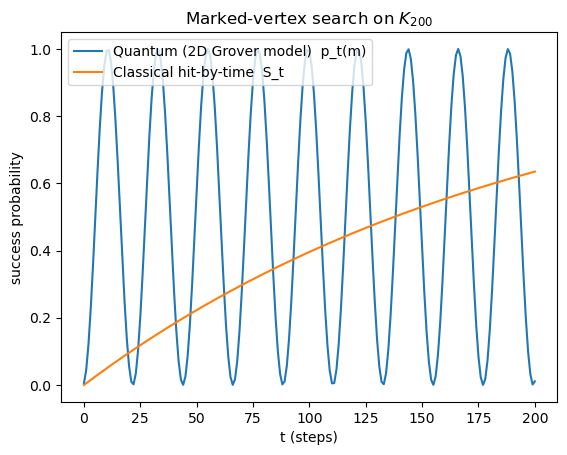

Classical one-step hit prob p_step = 0.005025  (expected scale ~ 199.0 steps)
Quantum theta = arcsin(1/sqrt(n)) = 0.070770


In [42]:
n = 200
T = 200  # enough to see the first big quantum peak (~O(sqrt(n)))

# classical hit-by-time baseline
S_classical, p_step, expected_scale = classical_hit_baseline_complete(n, T)

# quantum end-only success probability
p_quantum = quantum_search_2d_success_curve(n, T)

t = np.arange(T + 1)

plt.figure()
plt.plot(t, p_quantum, label="Quantum (2D Grover model)  p_t(m)")
plt.plot(t, S_classical, label="Classical hit-by-time  S_t")

plt.title(f"Marked-vertex search on $K_{{{n}}}$")
plt.xlabel("t (steps)")
plt.ylabel("success probability")
plt.legend()
plt.show()

print(f"Classical one-step hit prob p_step = {p_step:.6f}  (expected scale ~ {expected_scale:.1f} steps)")
print(f"Quantum theta = arcsin(1/sqrt(n)) = {np.arcsin(1/np.sqrt(n)):.6f}")


## F.4 Scaling plot across n

For each \(n\), we compute:

- Quantum \(T_{0.5}\): smallest \(t\) such that \(p_t(m) \ge 0.5\).
- Classical baseline \(T_{0.5}\): smallest \(t\) such that \(S_t \ge 0.5\) for \(S_t = 1-(1-1/(n-1))^t\).

We then plot these step counts versus \(n\).


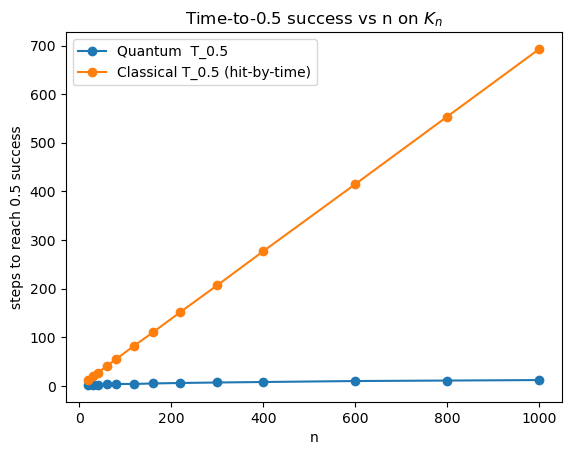

n=  20 | quantum T0.5=   2 | classical T0.5=  13
n=  30 | quantum T0.5=   2 | classical T0.5=  20
n=  40 | quantum T0.5=   2 | classical T0.5=  27
n=  60 | quantum T0.5=   3 | classical T0.5=  41
n=  80 | quantum T0.5=   4 | classical T0.5=  55
n= 120 | quantum T0.5=   4 | classical T0.5=  83
n= 160 | quantum T0.5=   5 | classical T0.5= 110
n= 220 | quantum T0.5=   6 | classical T0.5= 152
n= 300 | quantum T0.5=   7 | classical T0.5= 207
n= 400 | quantum T0.5=   8 | classical T0.5= 277
n= 600 | quantum T0.5=  10 | classical T0.5= 415
n= 800 | quantum T0.5=  11 | classical T0.5= 554
n=1000 | quantum T0.5=  12 | classical T0.5= 693


In [43]:
p_thresh = 0.5
n_values = [20, 30, 40, 60, 80, 120, 160, 220, 300, 400, 600, 800, 1000]

Tq_list = []
Tc_list = []

for n in n_values:
    # choose a horizon that comfortably contains the first quantum peak
    # peak is around ~ (pi/4)*sqrt(n), so 4*sqrt(n) is a safe visual budget
    T = int(np.ceil(4.0 * np.sqrt(n) + 10))

    p_quantum = quantum_search_2d_success_curve(n, T)
    S_classical, _, _ = classical_hit_baseline_complete(n, T)

    Tq = time_to_threshold(p_quantum, p=p_thresh)
    Tc = time_to_threshold(S_classical, p=p_thresh)

    # if not reached within horizon, extend (rare for these choices, but safe)
    if Tq is None:
        T2 = int(np.ceil(10.0 * np.sqrt(n) + 50))
        p_quantum = quantum_search_2d_success_curve(n, T2)
        Tq = time_to_threshold(p_quantum, p=p_thresh)

    if Tc is None:
        T2 = int(np.ceil(5.0 * (n - 1) + 10))
        S_classical, _, _ = classical_hit_baseline_complete(n, T2)
        Tc = time_to_threshold(S_classical, p=p_thresh)

    Tq_list.append(Tq)
    Tc_list.append(Tc)

# plot scaling
plt.figure()
plt.plot(n_values, Tq_list, marker="o", label="Quantum  T_0.5")
plt.plot(n_values, Tc_list, marker="o", label="Classical T_0.5 (hit-by-time)")

plt.title("Time-to-0.5 success vs n on $K_n$")
plt.xlabel("n")
plt.ylabel("steps to reach 0.5 success")
plt.legend()
plt.show()

# quick sanity prints
for n, tq, tc in zip(n_values, Tq_list, Tc_list):
    print(f"n={n:4d} | quantum T0.5={tq:4d} | classical T0.5={tc:4d}")


# Part G — Optional spectral visuals

We visualize **classical eigenvalues** versus **quantum eigenvalues** to reinforce the “contraction” (stochastic dynamics) versus “rotation” (unitary dynamics) viewpoint.

- For a classical random walk, the transition matrix `P` is **row-stochastic**, so its spectrum lies in/within the unit disk (typically inside, with a top eigenvalue at 1).
- For a coined quantum walk, one step is a **unitary** operator `U` on the joint coin–position space, so all eigenvalues lie **on** the unit circle.

## G.1 Eigenvalue plot for a small instance

We compute eigenvalues for a small `n` (so forming `U` explicitly is feasible) and plot them in the complex plane for quick qualitative comparison.


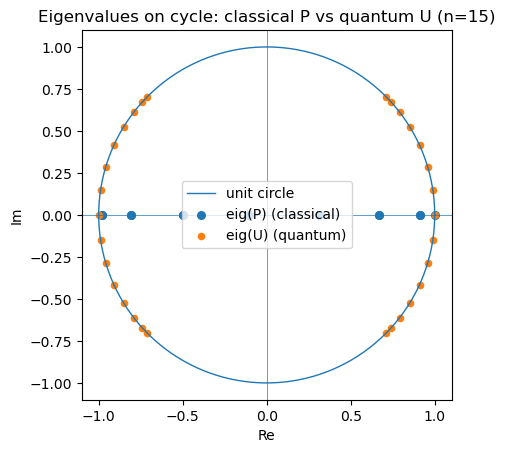

In [44]:
def build_unitary_from_step(n: int, C: np.ndarray, shift_fn) -> np.ndarray:
    """
    Build the explicit unitary step matrix U (size 2n x 2n) by applying the
    existing one-step routine to basis states.

    This is only meant for small n (O(n^2) construction).
    Basis ordering matches psi[v, c] flattened in row-major order.
    """
    dim = 2 * n
    U = np.zeros((dim, dim), dtype=complex)

    for j in range(dim):
        psi = np.zeros((n, 2), dtype=complex)
        v = j // 2
        c = j % 2
        psi[v, c] = 1.0 + 0.0j

        psi_next = quantum_step_degree2(psi, C, shift_fn)
        U[:, j] = psi_next.reshape(-1)  # same ordering as basis

    return U

n_small = 15

# Classical transition (cycle)
P = P_cycle(n_small)
evals_P = np.linalg.eigvals(P)

# Quantum step unitary (cycle, Hadamard coin)
C2 = coin_hadamard()
U = build_unitary_from_step(n_small, C2, shift_cycle)
evals_U = np.linalg.eigvals(U)

# Plot in Complex Plane
theta = np.linspace(0, 2*np.pi, 600)
unit_circle = np.exp(1j * theta)

plt.figure()
plt.plot(unit_circle.real, unit_circle.imag, linewidth=1, label="unit circle")
plt.scatter(evals_P.real, evals_P.imag, s=30, label="eig(P) (classical)")
plt.scatter(evals_U.real, evals_U.imag, s=20, label="eig(U) (quantum)")
plt.axhline(0, linewidth=0.5)
plt.axvline(0, linewidth=0.5)
plt.gca().set_aspect("equal", adjustable="box")
plt.title(f"Eigenvalues on cycle: classical P vs quantum U (n={n_small})")
plt.xlabel("Re")
plt.ylabel("Im")
plt.legend()
plt.show()
